In [2]:
import pandas as pd
import numpy as np

In [3]:
# Importo los datos como dataframe de pandas
real = pd.read_csv("Data/True.csv")
fake = pd.read_csv("Data/Fake.csv")

In [4]:
# Agrego etiquetas
real['fake?'] = 0
fake['fake?'] = 1

In [5]:
fake.head()

,title,text,subject,date,fake?
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [6]:
# Mezclamos los 2 dataframes y los ramdomisamos el orden
from sklearn.utils import shuffle

news = real.append(fake, ignore_index=True)
news = shuffle(news)
news

,title,text,subject,date,fake?
35681,IS HILLARY ABOUT TO BE “BERNED?”…Obama Tells D...,Hillary is failing miserably with the young vo...,politics,"Mar 18, 2016",1
8387,Tech firms' encryption foe struggles for U.S. ...,WASHINGTON (Reuters) - A U.S. senator seen by ...,politicsNews,"August 25, 2016",0
9792,U.S. top court backs New Jersey cop's politica...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"April 26, 2016",0
34044,BIGOT OBAMA EXCLUDED White Christians In List ...,It s difficult to tell what Obama s doing with...,politics,"Oct 25, 2016",1
34856,UNREAL! HERE’S WHY OBAMA SAYS He Stopped Using...,WOW! At About the 14:00 minute mark you ll hea...,politics,"Jul 25, 2016",1
...,...,...,...,...,...
43021,MACY’S CELEBRATES AMERICA’S INDEPENDENCE BY PU...,Americans need to put American citizens first ...,left-news,"Jul 1, 2015",1
33026,Ignorance Gave GITMO Prisoner FREEDOM…UK Gave ...,Tolerance + trust = human bombs for Islamic te...,politics,"Feb 21, 2017",1
35553,HILARIOUS! SATURDAY NIGHT LIVE Mocks Hillary’s...,"Yep, she s just like you and me!",politics,"Apr 10, 2016",1
26267,CNN Guest SMACKS DOWN Trump Supporter For Rac...,Infamous Donald Trump surrogate and supporter ...,News,"August 30, 2016",1


In [7]:
#Combinamos columnas de texto
news['text'] = news['title'] + " " + news['text']
news.drop(['title', 'subject', 'date'], axis=1, inplace=True)
news = news.drop_duplicates(['text', 'fake?'])
news.sample(5)

,text,fake?
41741,OHIO COLLEGE PROFESSOR Makes Threatening Post ...,1
19819,"Peru's Kuczynski swears in new Cabinet, opposi...",0
15038,Ireland will not threaten to veto Brexit talks...,0
14508,"EU's Tusk: no deadlock on Brexit, very cautiou...",0
24569,Republicans Vote To DEFUND The U.N. In Retali...,1


In [8]:
news.shape

(39105, 2)

In [9]:
news['fake?'].value_counts()

0    21197
1    17908
Name: fake?, dtype: int64

In [10]:
# Se separan el dataset en los sets de train (luego el de train en validacion) y el de test
# este enfoque se justifica previo a la tokenizacion
from sklearn.model_selection import train_test_split

train, test = train_test_split(news, test_size=0.3, random_state=42)
train, validation = train_test_split(train, test_size = 0.2, random_state=42)
print(len(train), len(validation), len(test) )

21898 5475 11732


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
filtrar = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' #Hay un problema con ' quizas se puede resolver en un paso previo

tokenizer = Tokenizer(filters=filtrar, lower=True, split=" ")
tokenizer.fit_on_texts(train.text)
word_index = tokenizer.word_index

In [12]:
train_matrix = tokenizer.texts_to_sequences(np.array(train.text))
val_matrix = tokenizer.texts_to_sequences(np.array(validation.text))
test_matrix = tokenizer.texts_to_sequences(np.array(test.text))


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_matrix = pad_sequences(train_matrix, maxlen=2048, padding="post", truncating="post")
val_matrix = pad_sequences(val_matrix, maxlen=2048, padding="post", truncating="post")
test_matrix = pad_sequences(test_matrix, maxlen=2048, padding="post", truncating="post")

In [14]:
type(train_matrix)

numpy.ndarray

In [15]:
train_matrix.shape

(21898, 2048)

In [16]:
train_matrix[0]

array([84, 65, 38, ...,  0,  0,  0], dtype=int32)

In [17]:
val_matrix.shape

(5475, 2048)

In [ ]:
test_matrix.shape

(13470, 2048)

In [20]:
x_train = np.copy(train_matrix)
x_val = np.copy(val_matrix)
x_test = np.copy(test_matrix)
y_train = train['fake?'].values
y_val = validation['fake?'].values
y_test = test['fake?'].values


### Aqui comienza la configuracion y entrenamiento de la red base

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, GlobalAveragePooling1D, BatchNormalization

EMBEDDINGS_DIMENSION = 20

# Creamos un modelo con dos capas ocultas de 16 neuronas cada una
model = Sequential(name="modelo_base")
model.add(Embedding(trainable=True,
    input_length=(x_train.shape[1]),
    output_dim=EMBEDDINGS_DIMENSION,
    input_dim=(len(tokenizer.word_counts) + 1)))

model.add(Bidirectional(GRU(EMBEDDINGS_DIMENSION, return_sequences=True)))
model.add(Bidirectional(GRU(EMBEDDINGS_DIMENSION)))

model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "modelo_base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2048, 20)          2177760   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2048, 40)          5040      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                7440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 

In [26]:
# Compilamos el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
# Entrenamos
history = model.fit(x=x_train, y=y_train,
                    epochs=4, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/4
43/43 [==============================] - 25s 583ms/step - loss: 0.4401 - accuracy: 0.7758 - val_loss: 0.5460 - val_accuracy: 0.9483
Epoch 2/4
43/43 [==============================] - 24s 558ms/step - loss: 0.0452 - accuracy: 0.9904 - val_loss: 0.1970 - val_accuracy: 0.9967
Epoch 3/4
43/43 [==============================] - 24s 557ms/step - loss: 0.0090 - accuracy: 0.9997 - val_loss: 0.0974 - val_accuracy: 0.9987
Epoch 4/4
43/43 [==============================] - 24s 556ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 0.9991


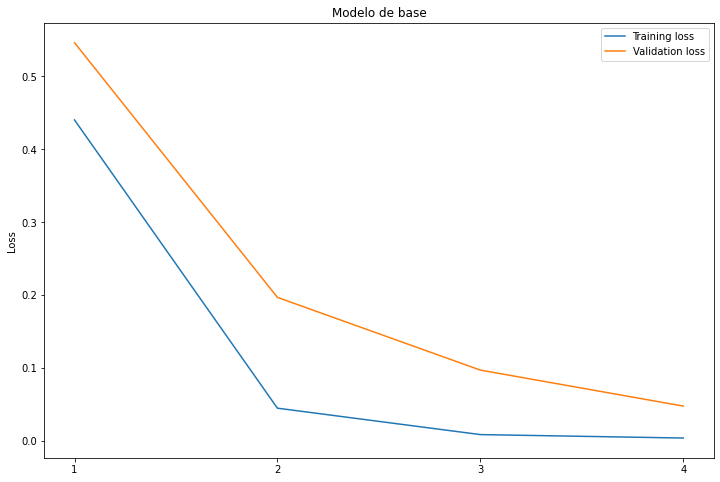

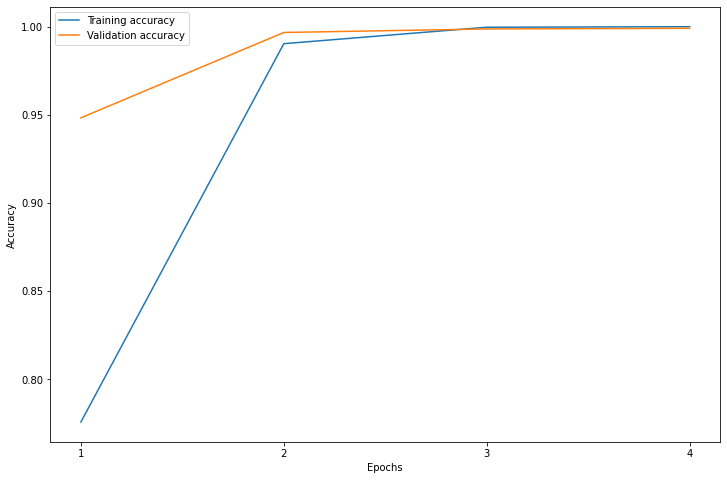

In [28]:
import matplotlib.pyplot as plt
# El atributo `history` contiene un diccionario de métricas por epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.title('Modelo de base')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.figure(figsize=(12,8))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=list(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy']);

### Testeo

In [29]:
y_pred = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [30]:
y_pred.shape

(11732, 1)

In [31]:
np.reshape(y_pred, y_pred.shape[0])

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [32]:
y_test[0:5]

array([0, 1, 1, 1, 0])

In [33]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test, y_pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      6334
    Not Fake       1.00      1.00      1.00      5398

    accuracy                           1.00     11732
   macro avg       1.00      1.00      1.00     11732
weighted avg       1.00      1.00      1.00     11732



In [34]:
cm = confusion_matrix(y_test, y_pred , labels=[0, 1])


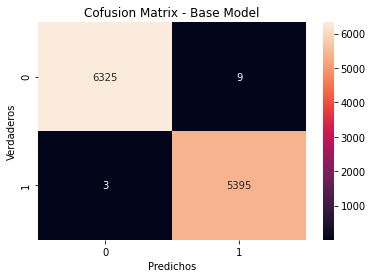

In [35]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='.0f')
plt.ylabel('Verdaderos')
plt.title('Cofusion Matrix - Base Model')
plt.xlabel('Predichos');